In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [198]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [2, 2],
    1: [4, 1],
    2: [3, 5],
    3: [6, 3]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 100
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

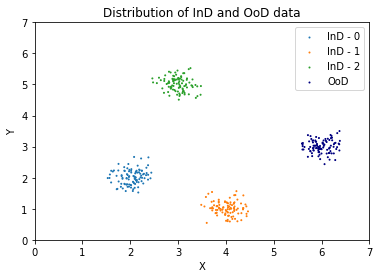

In [199]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

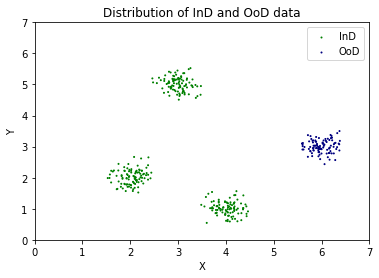

In [200]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [201]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 100
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

 11%|█         | 11/100 [00:00<00:00, 106.32it/s]

Epoch  # 1 | Tri loss: 1.1004                     | Tri accuracy: 0.3459
Epoch  # 1 | Val loss: 1.046                     | Val accuracy: 0.3365


 67%|██████▋   | 67/100 [00:00<00:00, 127.73it/s]

Epoch  # 51 | Tri loss: 0.0624                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0662                     | Val accuracy: 1.0


100%|██████████| 100/100 [00:00<00:00, 124.94it/s]


#### Plot

In [202]:
xi = np.linspace(0, 8, 100, endpoint=True)
yi = np.linspace(0, 8, 100, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
x, y = np.concatenate((IND_X[:,0],OOD_X[:,0])), np.concatenate((IND_X[:,1],OOD_X[:,1]))
zi = torch.softmax(D(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


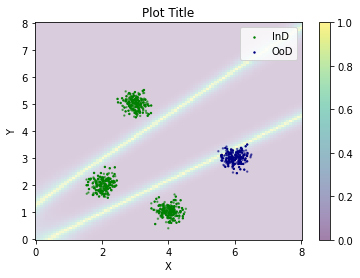

In [204]:
from wasserstein import *
plt.pcolormesh(xi, yi, si.reshape((100, 100)).T, shading='auto', cmap="viridis", alpha=0.2)
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[2]*len(IND_X), alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", sizes=[2]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='green', sizes=[2]*len(IND_X), alpha=0.50)
plt.scatter(OOD_X_TEST[:,0], OOD_X_TEST[:,1], c='navy', sizes=[2]*len(OOD_X), alpha=0.50)
plt.title("Plot Title")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.colorbar()
plt.savefig("heatmap.jpg", dpi=1000)
plt.show()

### WOOD Training

In [263]:
from simulation import *
D_WOOD = DSIM()
# OOD data preparation
n_ood = 8
ood_bsz = 8
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)

OOD Batch Shape: torch.Size([8, 2])


  1%|          | 1/128 [00:00<00:30,  4.23it/s]

Epoch  # 1 | Tri loss: 1.0594                     | Tri accuracy: 0.3365
Epoch  # 1 | Val loss: 1.1123                     | Val accuracy: 0.2988


 41%|████      | 52/128 [00:08<00:13,  5.63it/s]

Epoch  # 51 | Tri loss: 0.6021                     | Tri accuracy: 0.7179
Epoch  # 51 | Val loss: 0.6203                     | Val accuracy: 0.7409


 80%|███████▉  | 102/128 [00:17<00:04,  6.35it/s]

Epoch  # 101 | Tri loss: 0.2557                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.3294                     | Val accuracy: 1.0


100%|██████████| 128/128 [00:22<00:00,  5.81it/s]


In [264]:
m = 100
xi = np.linspace(0, 8, m, endpoint=True)
yi = np.linspace(0, 8, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_WOOD(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


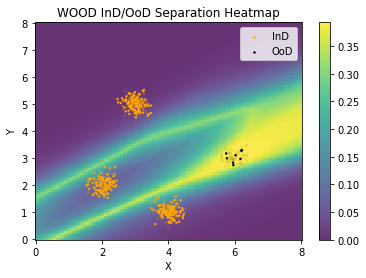

In [265]:
from wasserstein import *
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto', alpha=0.8)
plt.colorbar()
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", sizes=[2]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='black', label="OoD", sizes=[2]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='orange', sizes=[2]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='black', sizes=[2]*len(OOD_X), alpha=0.05)
plt.title("WOOD InD/OoD Separation Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.savefig("simulation_log/plot/wood_heatmap.jpg", dpi=1000)
plt.show()

### OOD GAN Training

In [289]:
from simulation import *
# D_GAN = DSIM(128)
# G_GAN = GSIM(128)
# OOD data preparation
# n_ood = 64
ood_bsz = 8
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
w_ce, w_wass, w_dist = 1, 0.1, 0.0
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([8, 2])


  0%|          | 0/64 [00:00<?, ?it/s]

Step: 0    | D:  0.2611 | CE:  0.2608 | W_OoD:  0.9585 | W_z:  0.9491 | G:  0.0380 | W_z:  0.9680 | dist: 4.7462


  2%|▏         | 1/64 [00:02<02:51,  2.72s/it]

Epoch  # 1 | Val accuracy: 1.0


  8%|▊         | 5/64 [00:13<02:34,  2.63s/it]

Step: 0    | D:  0.2324 | CE:  0.2309 | W_OoD:  0.9856 | W_z:  0.9450 | G:  0.0388 | W_z:  0.9470 | dist: 4.7594


  9%|▉         | 6/64 [00:15<02:28,  2.56s/it]

Epoch  # 6 | Val accuracy: 1.0


 16%|█▌        | 10/64 [00:25<02:13,  2.47s/it]

Step: 0    | D:  0.2318 | CE:  0.2302 | W_OoD:  0.9902 | W_z:  0.9458 | G:  0.0389 | W_z:  0.9437 | dist: 4.7822


 17%|█▋        | 11/64 [00:27<02:10,  2.46s/it]

Epoch  # 11 | Val accuracy: 1.0


 23%|██▎       | 15/64 [00:37<02:00,  2.46s/it]

Step: 0    | D:  0.2233 | CE:  0.2232 | W_OoD:  0.9495 | W_z:  0.9467 | G:  0.0385 | W_z:  0.9552 | dist: 4.8079


 23%|██▎       | 15/64 [00:39<02:10,  2.65s/it]


KeyboardInterrupt: 

In [290]:
m = 100
xi = np.linspace(0, 8, m, endpoint=True)
yi = np.linspace(0, 8, m, endpoint=True)
xy_pos = np.array(list(product(xi, yi)))
zi = torch.softmax(D_GAN(torch.tensor(xy_pos, dtype=torch.float32)), dim=-1)
print(zi.shape)
si = ood_wass_loss(zi)

torch.Size([10000, 3])


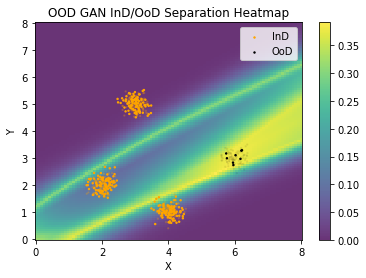

In [291]:
from wasserstein import *
plt.pcolormesh(xi, yi, si.reshape((m, m)).T, shading='auto', alpha=0.8)
plt.colorbar()
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", sizes=[2]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='black', label="OoD", sizes=[2]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0], IND_X_TEST[:,1], c='orange', sizes=[2]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='black', sizes=[2]*len(OOD_X), alpha=0.05)
plt.title("OOD GAN InD/OoD Separation Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.savefig("simulation_log/plot/oodgan_heatmap1.jpg", dpi=1000)
plt.show()

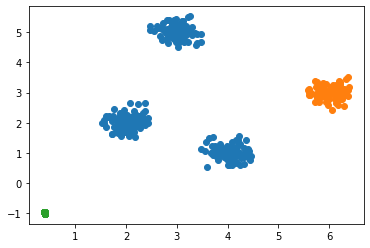

In [292]:
seed = torch.rand((128, 1))
gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0], IND_X[:,1])
plt.scatter(OOD_X[:,0], OOD_X[:,1])
plt.scatter(gz[:,0], gz[:,1])
plt.show()

In [299]:
from simulation import calculate_accuracy
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)

torch.Size([300, 3])
torch.Size([300])
0.00822144187986851
torch.Size([100, 3])
tensor(0.7200)


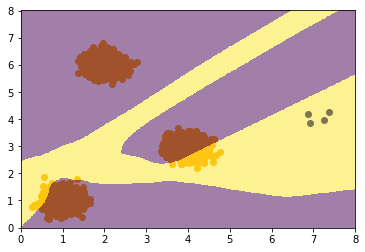

In [90]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)

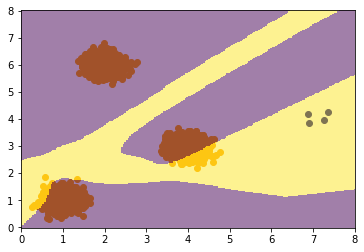

In [88]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)